# Section 0:

This project is devoted to analysis of S&P500 stock prices:

- downloading the data from Yfinance, FRED, parsing Wikipedia
- distribution of returns
- Sharpe-Ratio analysis


# Section 1

## 1.1: Download Daily Stock Prices for FAANG Stocks

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import skew, kurtosis,shapiro, kstest, normaltest, anderson
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader.data as web
import datetime

/Users/aleksandrmikhailov/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Download daily stock prices via yahoo finance
tickers = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
start_date = '2015-01-01'
end_date = '2020-12-31'

# Adjusted closing prices
faang_prices_daily = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

faang_prices_daily.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2015-01-02 00:00:00+00:00,24.347176,15.4260,26.104546,78.214508,49.848572
2015-01-05 00:00:00+00:00,23.661263,15.1095,25.560379,76.958290,47.311428
2015-01-06 00:00:00+00:00,23.663498,14.7645,24.967964,75.921410,46.501431
2015-01-07 00:00:00+00:00,23.995316,14.9210,24.925190,75.921410,46.742859
2015-01-08 00:00:00+00:00,24.917265,15.0230,25.003778,77.945320,47.779999


## 1.2: Compute the first and second moments of stock returns for each of these stocks

In [8]:
# Find Daily returns
faang_returns_daily = faang_prices_daily.pct_change().dropna()

In [9]:
# Mean daily return 
mean_faang_returns_daily = faang_returns_daily.mean()
print("\nMean Daily Returns of FAANG:")
print(mean_faang_returns_daily)


Mean Daily Returns of FAANG:
Ticker
AAPL    0.001289
AMZN    0.001757
GOOG    0.000939
META    0.001027
NFLX    0.001914
dtype: float64


In [10]:
# Sample Variance of daily returns 
# use ddof 1 to have unbiased estimate of variance
variances_faang_returns_daily = faang_returns_daily.var(ddof = 1) 
print("\nVariances of Daily Returns of FAANG:")
print(variances_faang_returns_daily)


Variances of Daily Returns of FAANG:
Ticker
AAPL    0.000349
AMZN    0.000381
GOOG    0.000288
META    0.000403
NFLX    0.000715
dtype: float64


In [11]:
#results
mean_variance_df = pd.DataFrame(
                {'Mean' : mean_faang_returns_daily,
                'Variance' : variances_faang_returns_daily},
                index = faang_returns_daily.columns)

print('below the mean and variance per stock in % : ')
print(mean_variance_df*100)

below the mean and variance per stock in % : 
            Mean  Variance
Ticker                    
AAPL    0.128899  0.034862
AMZN    0.175748  0.038119
GOOG    0.093936  0.028784
META    0.102660  0.040293
NFLX    0.191444  0.071513


Draw a scatter plot that shows realized daily returns and standard deviations of faang stocks

In [12]:
def scatter_plot_return_volatility(volatilities: np.array,  # volatilities vector
                                   returns: np.array,       # returns vector
                                   ticker_fontsize: int = 7 # size of the ticker
                                  ):
    """
    This graph plots returns and volatilities in a scatterplot.
    Like for Markowitz portfolio optimization
    """

    # Create a scatter plot
    plt.figure(figsize=(10, 7), dpi = 200)
    plt.scatter(volatilities, returns, color='blue')
    
    # Annotate each point with its ticker
    for ticker, x, y in zip(returns.index, volatilities, returns):
        plt.text(x, y, ticker, fontsize=ticker_fontsize, ha='right')
    
    plt.title('Scatter Plot of Volatilities vs MeanReturns')
    plt.xlabel('Volatility')
    plt.ylabel('Mean Return')
    plt.grid(True)
    plt.show()

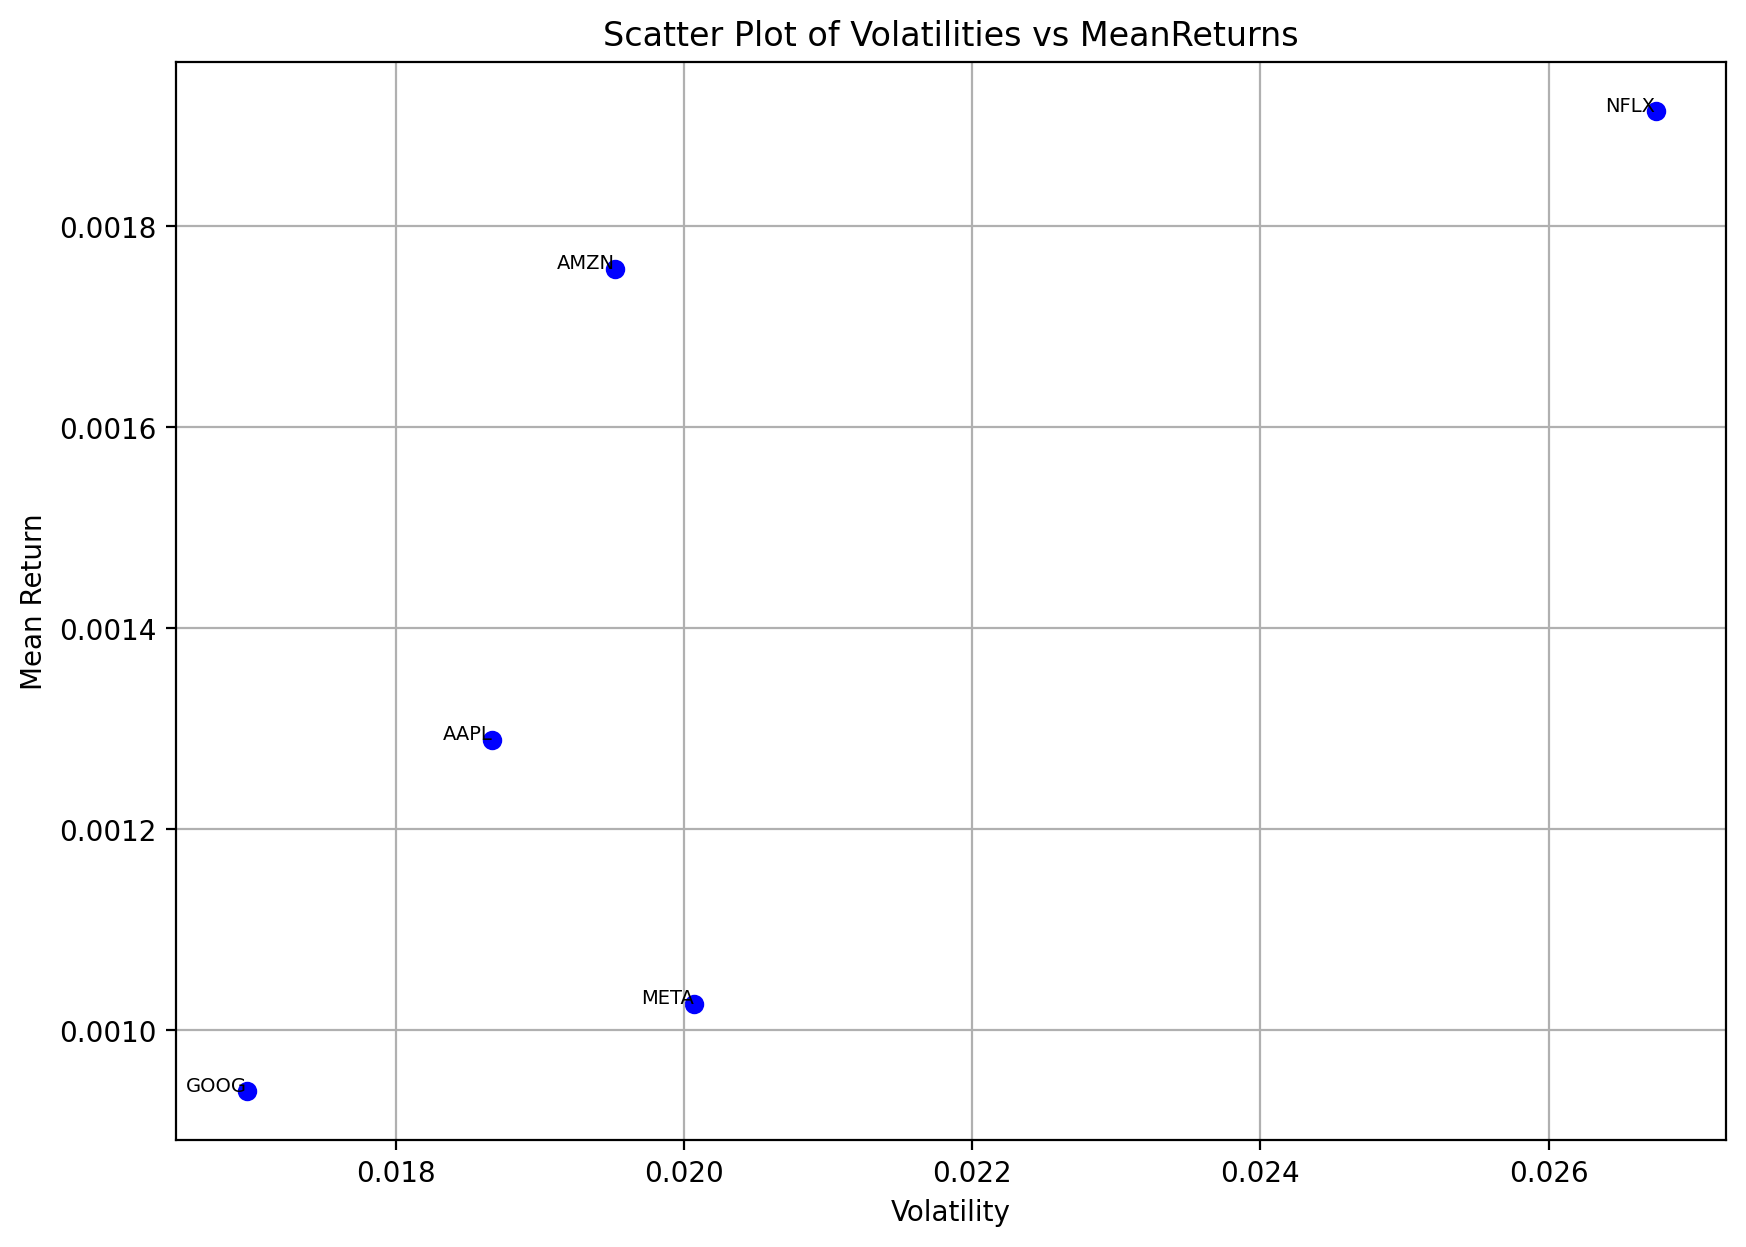

In [13]:
# Calculate standard deviations from the variances
stds_faang_returns_daily = variances_faang_returns_daily ** 0.5
# plot them
scatter_plot_return_volatility(stds_faang_returns_daily, mean_faang_returns_daily)

I do not see any clear relationship between risk and return from this representation.

In [14]:
#Covariance of daily return
cov_matrix = faang_returns_daily.cov()
cov_matrix

Ticker,AAPL,AMZN,GOOG,META,NFLX
Ticker,,,,,
AAPL,0.000349,0.000202,0.000192,0.000216,0.000206
AMZN,0.000202,0.000381,0.000216,0.000235,0.000275
GOOG,0.000192,0.000216,0.000288,0.000228,0.000216
META,0.000216,0.000235,0.000228,0.000403,0.000238
NFLX,0.000206,0.000275,0.000216,0.000238,0.000715


Let's draw a heatmap displaying covariance among the different stock daily returns

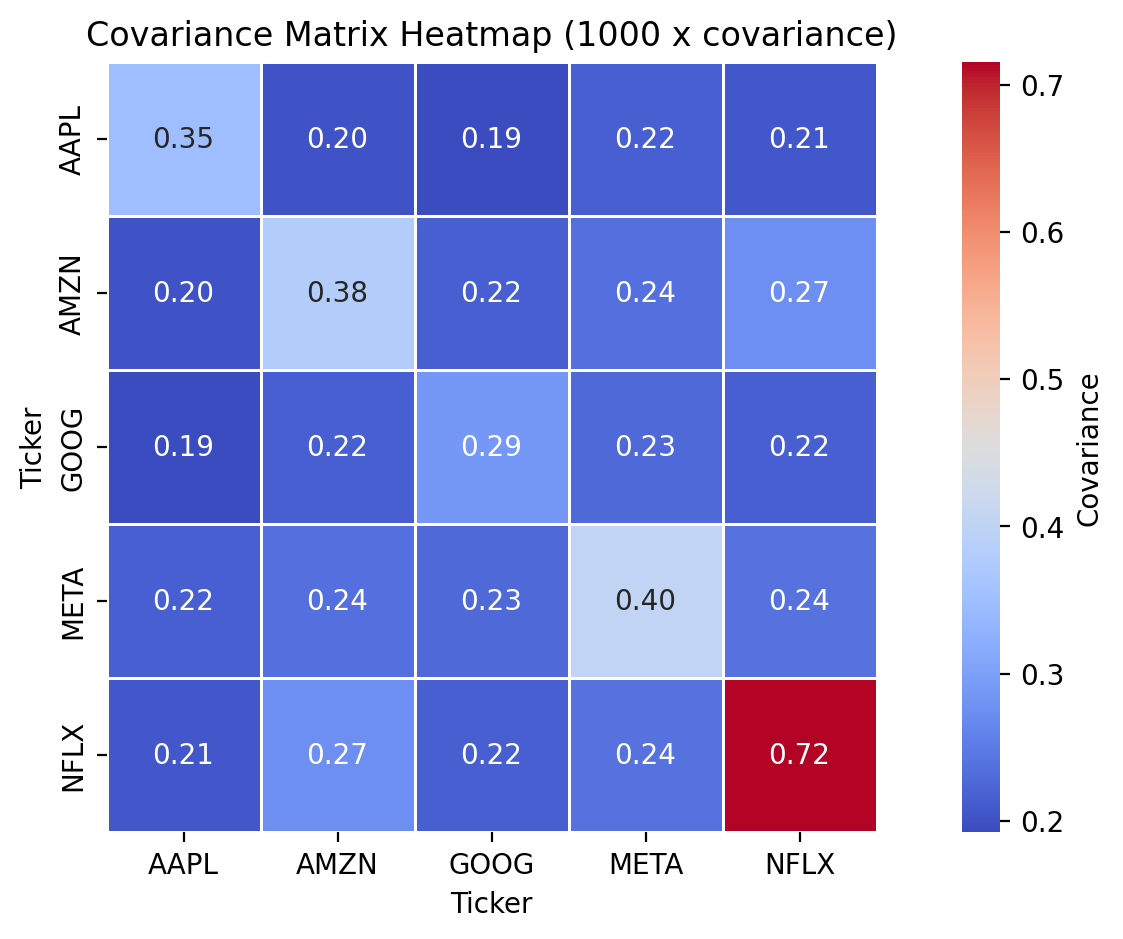

In [18]:
#heatmap
plt.figure(figsize=(11, 5), dpi = 200)
sns.heatmap(cov_matrix*1000, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Covariance'}, square=True, linewidths=0.5)
plt.title("Covariance Matrix Heatmap (1000 x covariance)")
plt.show()

The covariances appear very low, to the extent that we had to multiply it by 1000 to achieve non-zero levels in our graph. This seems odd, as one might expect FANG stock returns to be strongly correlated. However, the key here is that we're looking at daily returns. While FANG stock returns might be correlated, this correlation may not be as visible on a daily scale since daily returns can vary independently. To see potential correlations more clearly, one might need to use a longer time window.

## 1.3 Compute the skewness and excess kurtosis for the returns for each of these stocks. Look at distributions

In [19]:
# Skewness
faang_skewnes_daily = faang_returns_daily.dropna().apply(skew)
print("\nSkewness of Daily Returns:")
print(faang_skewnes_daily)

# Excess kurtosis 
faang_kurtosis_daily = faang_returns_daily.dropna().apply(kurtosis)
faang_excess_kurtosis_daily = faang_kurtosis_daily -3
print("\nExcess Kurtosis of Daily Returns:")
print(faang_excess_kurtosis_daily)


Skewness of Daily Returns:
Ticker
AAPL   -0.082903
AMZN    0.758752
GOOG    0.517318
META   -0.329612
NFLX    0.681363
dtype: float64

Excess Kurtosis of Daily Returns:
Ticker
AAPL    3.584465
AMZN    4.171822
GOOG    7.394842
META    8.997576
NFLX    4.322442
dtype: float64


Run Shapiro-Wilk Test on normality distribition of stock returns

In [20]:
faang_returns_daily = faang_returns_daily.dropna()
print("\nShapiro-Wilk Test:")
print()
for ticker in tickers:
    stat, p_value = shapiro(faang_returns_daily[ticker])
    print(f"{ticker}: W-statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject the null hypothesis (data is normally distributed)")
    else:
        print("Reject the null hypothesis (data is not normally distributed)")
    print()


Shapiro-Wilk Test:

META: W-statistic=0.8922, p-value=0.0000
Reject the null hypothesis (data is not normally distributed)

AMZN: W-statistic=0.9122, p-value=0.0000
Reject the null hypothesis (data is not normally distributed)

AAPL: W-statistic=0.9195, p-value=0.0000
Reject the null hypothesis (data is not normally distributed)

NFLX: W-statistic=0.9211, p-value=0.0000
Reject the null hypothesis (data is not normally distributed)

GOOG: W-statistic=0.8984, p-value=0.0000
Reject the null hypothesis (data is not normally distributed)



Run Kolmogorov-Smirno Test on normality distribition of stock returns

In [21]:
# Kolmogorov-Smirnov Test
print("\nKolmogorov-Smirnov Test:")
print()
for ticker in tickers:
    # Standardize the data
    standardized_data = (faang_returns_daily[ticker] - mean_faang_returns_daily[ticker]) / stds_faang_returns_daily
    stat, p_value = kstest(standardized_data, 'norm')
    print(f"{ticker}: KS-statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("Fail to reject the null hypothesis (data is normally distributed)")
    else:
        print("Reject the null hypothesis (data is not normally distributed)")
    print()


Kolmogorov-Smirnov Test:

META: KS-statistic=nan, p-value=nan
Reject the null hypothesis (data is not normally distributed)

AMZN: KS-statistic=nan, p-value=nan
Reject the null hypothesis (data is not normally distributed)

AAPL: KS-statistic=nan, p-value=nan
Reject the null hypothesis (data is not normally distributed)

NFLX: KS-statistic=nan, p-value=nan
Reject the null hypothesis (data is not normally distributed)

GOOG: KS-statistic=nan, p-value=nan
Reject the null hypothesis (data is not normally distributed)



Run Anderson-Darling Test on normality distribition of stock returns

In [22]:
# Anderson-Darling Test
print("\nAnderson-Darling Test:")
print()
for ticker in tickers:
    result = anderson(faang_returns_daily[ticker], dist='norm')
    print(f"{ticker}: A^2 statistic={result.statistic:.4f}")
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f"At {sl}% significance level: Fail to reject the null hypothesis (data is normally distributed)")
        else:
            print(f"At {sl}% significance level: Reject the null hypothesis (data is not normally distributed)")
        print()


Anderson-Darling Test:

META: A^2 statistic=27.3906
At 15.0% significance level: Reject the null hypothesis (data is not normally distributed)

At 10.0% significance level: Reject the null hypothesis (data is not normally distributed)

At 5.0% significance level: Reject the null hypothesis (data is not normally distributed)

At 2.5% significance level: Reject the null hypothesis (data is not normally distributed)

At 1.0% significance level: Reject the null hypothesis (data is not normally distributed)

AMZN: A^2 statistic=26.3575
At 15.0% significance level: Reject the null hypothesis (data is not normally distributed)

At 10.0% significance level: Reject the null hypothesis (data is not normally distributed)

At 5.0% significance level: Reject the null hypothesis (data is not normally distributed)

At 2.5% significance level: Reject the null hypothesis (data is not normally distributed)

At 1.0% significance level: Reject the null hypothesis (data is not normally distributed)

AAPL:

**All statistical tests indicate that the data are not normally distributed.**

Make QQ-Plots to show that the returns are not normally distributed

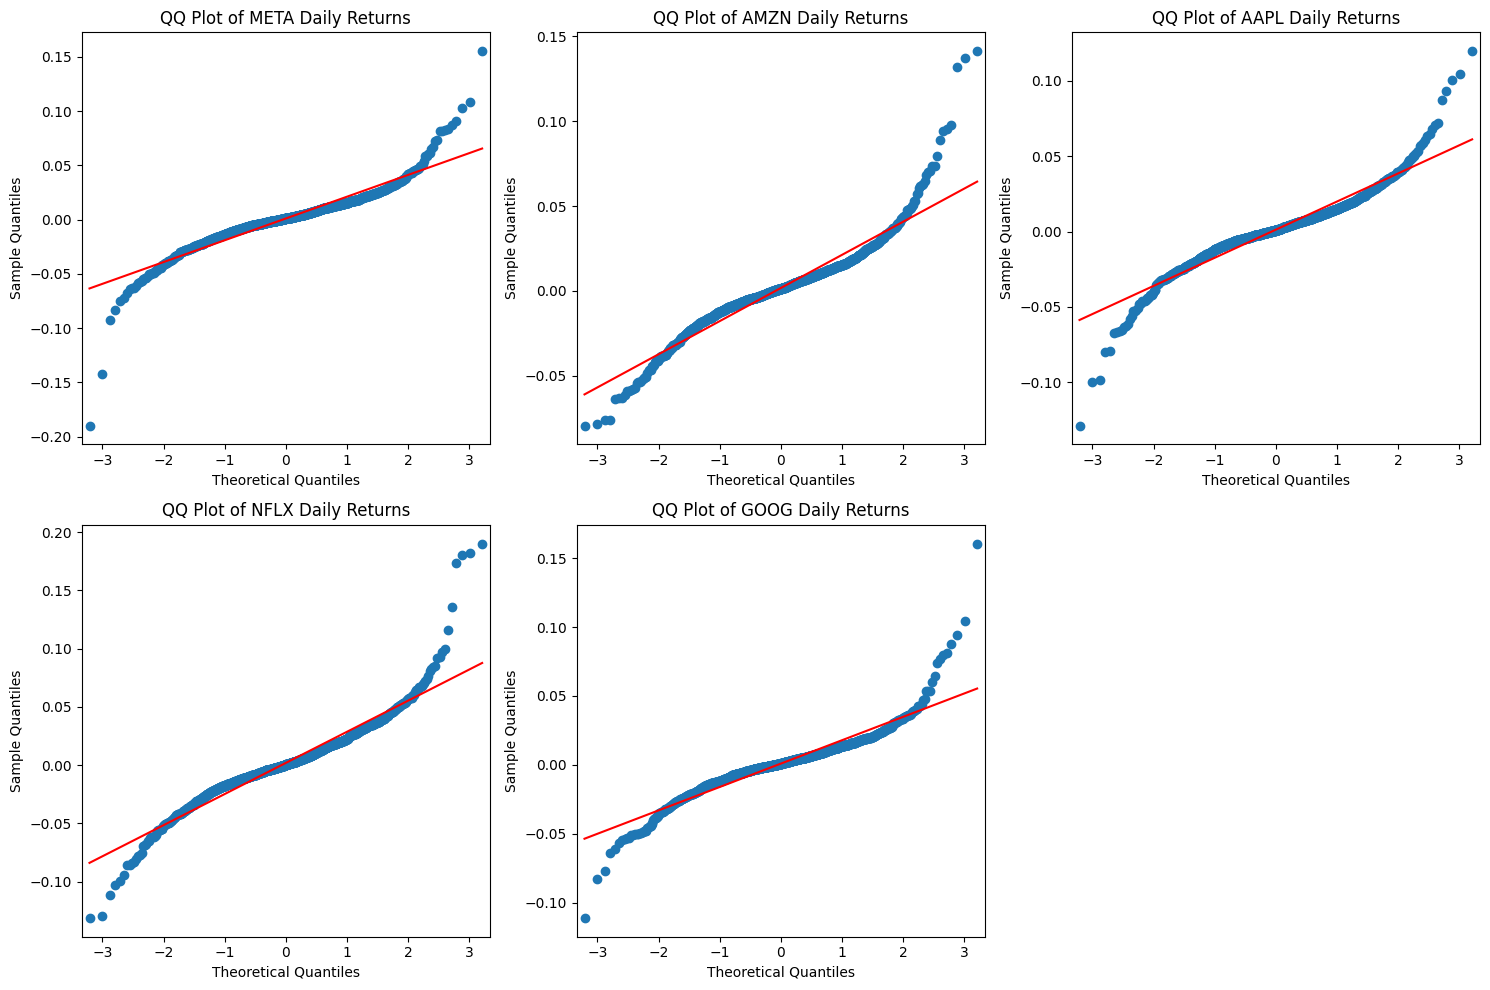

In [23]:
#QQ plots
fig, axes = plt.subplots((len(tickers) + 2) // 3, 3, figsize=(15, (len(tickers) // 3 + 1) * 5))
axes = axes.flatten()  # Flatten axes to easily iterate

for i, ticker in enumerate(tickers):
    sm.qqplot(faang_returns_daily[ticker], line='s', ax=axes[i])
    axes[i].set_title(f'QQ Plot of {ticker} Daily Returns')

# If there is an unused subplot, hide it
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Tails are strongly deviating from normal distribution behavior.

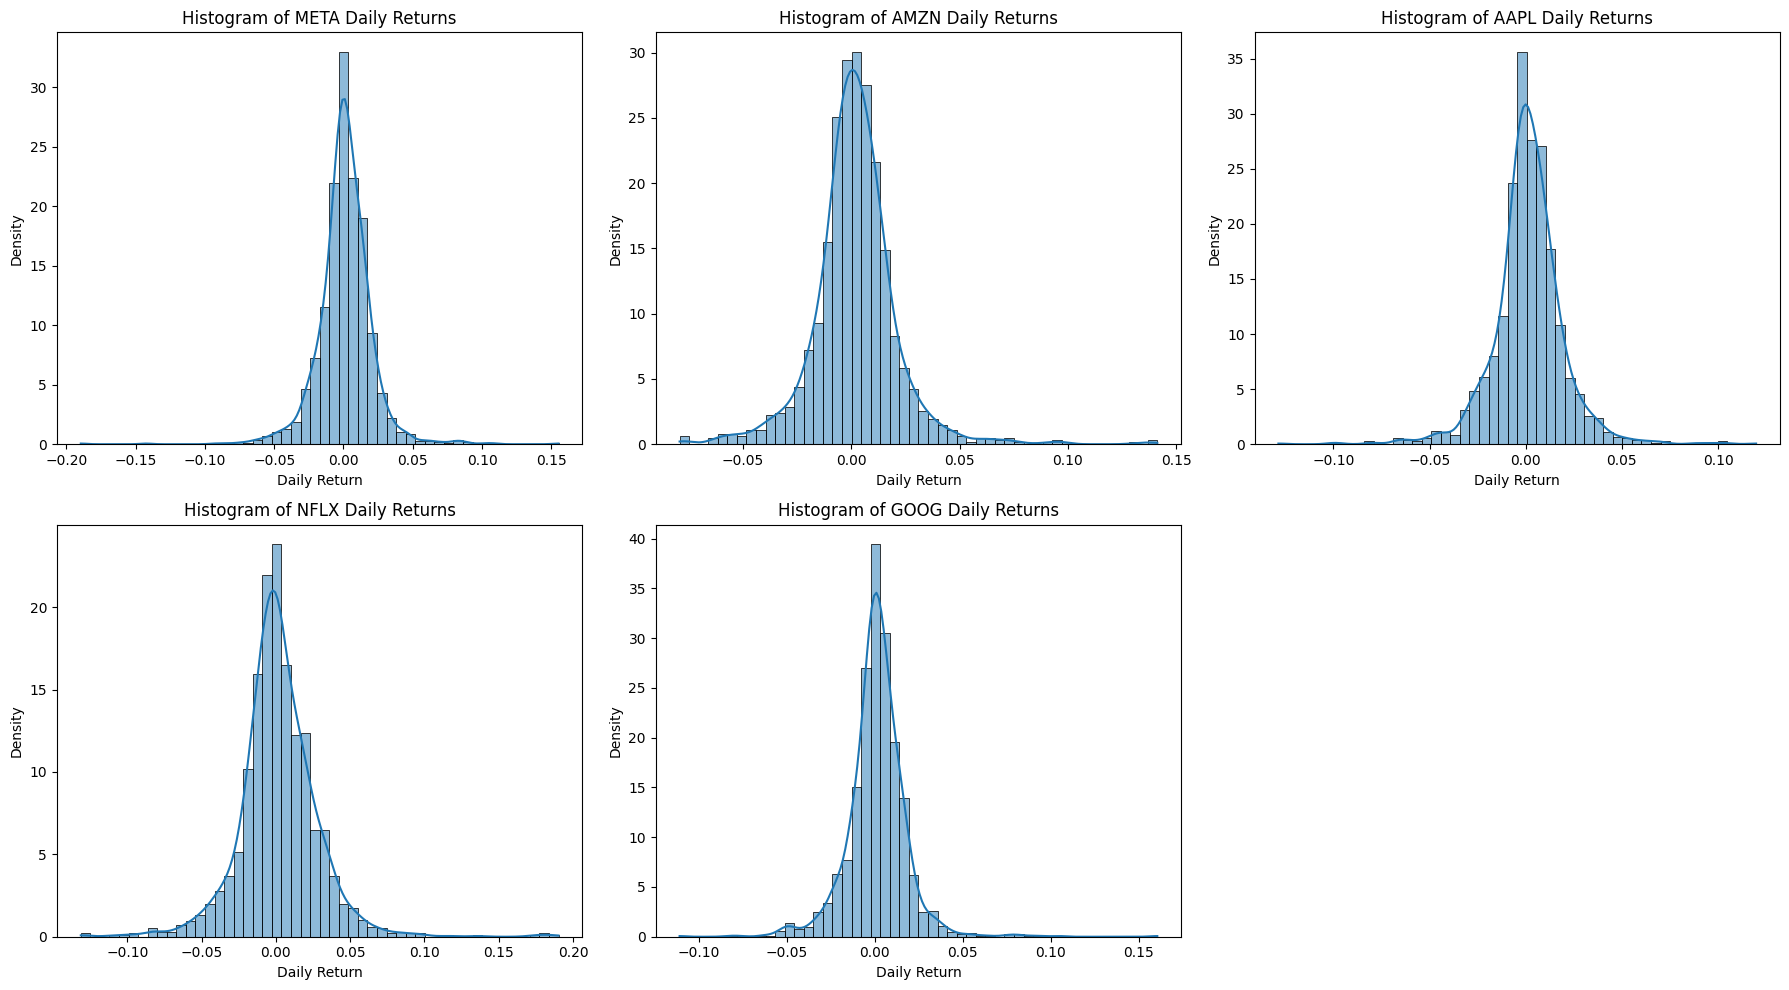

In [24]:
#distributions
fig, axes = plt.subplots((len(tickers) + 2) // 3, 3, figsize=(18, (len(tickers) // 3 + 1) * 5))
axes = axes.flatten()  # Flatten axes to easily iterate

for i, ticker in enumerate(tickers):
    sns.histplot(faang_returns_daily[ticker], kde=True, bins=50, stat="density", ax=axes[i])
    axes[i].set_title(f'Histogram of {ticker} Daily Returns')
    axes[i].set_xlabel('Daily Return')
    axes[i].set_ylabel('Density')

# If there is an unused subplot, hide it
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Daily stock returns **do not** have a Normal distribution

# Section 2:

## 2.1: Loading S&P 500 tickers from helpful links with Danny Groves

In [25]:
# As SSL verification is enabled, we need to import SSL
import ssl

In [26]:
## Disabling SSL certificate verification to read data from Wikipedia
ssl._create_default_https_context = ssl._create_unverified_context

# URL for the Wikipedia page with the S&P 500 table
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Use pandas to read all tables from the Wikipedia page
tables = pd.read_html(url)

# getting the first column of the tables as it contains the tickers
sp500_table = tables[0]

In [27]:
print(sp500_table.shape)
sp500_table.head(5)

(503, 8)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [28]:
# Extracting tickers from the Symbol column
sp500_tickers = sp500_table['Symbol'].tolist()

# Counting the number of tickers for verification
print(f"Number of tickers loaded: {len(sp500_tickers)}")

# Setting start date and end date
start_date = '2000-01-01'
end_date = '2022-12-31'

# Download stock price data for S&P 500 tickers
sp500_prices = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']
sp500_prices.head(5)

[                       0%                       ]

Number of tickers loaded: 503


[**********************79%*************          ]  397 of 503 completedCould not get exchangeTimezoneName for ticker 'LRCX' reason: 'chart'
[*********************100%***********************]  503 of 503 completed

9 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2000-01-01 -> 2022-12-31)')
['SW', 'GEV', 'SOLV', 'AMTM', 'VLTO', 'KVUE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2000-01-01 -> 2022-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 946702800, endDate = 1672462800")')
['BRK.B', 'LRCX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,43.463024,0.843077,NaN,NaN,8.288182,1.215037,NaN,16.274675,28.214651,6.248421,...,NaN,11.352947,NaN,6.848379,17.888821,NaN,4.634287,NaN,25.027779,NaN
2000-01-04 00:00:00+00:00,40.142921,0.771997,NaN,NaN,8.051376,1.208433,NaN,14.909397,26.787306,6.183336,...,NaN,10.926453,NaN,7.006066,17.546186,NaN,4.541135,NaN,24.666668,NaN
2000-01-05 00:00:00+00:00,37.652870,0.783293,NaN,NaN,8.036573,1.320692,NaN,15.204174,27.178364,6.085702,...,NaN,11.505265,NaN,7.276398,18.502733,NaN,4.564423,NaN,25.138889,NaN
2000-01-06 00:00:00+00:00,36.219185,0.715509,NaN,NaN,8.317780,1.307485,NaN,15.328290,26.435349,6.118244,...,NaN,12.043466,NaN,7.208816,19.459274,NaN,4.525611,NaN,23.777779,NaN
2000-01-07 00:00:00+00:00,39.237450,0.749401,NaN,NaN,8.406586,1.380124,NaN,16.072985,27.178364,6.215877,...,NaN,11.647432,NaN,7.208816,19.402172,NaN,4.424696,NaN,23.513889,NaN


I have downloaded all adjusted daily prices and now drop those that contain NaNs

In [29]:
# Dropping columns with only missing values
sp500_prices = sp500_prices.dropna(how='all', axis=1)

In [30]:
# Dropping columns with more than 100 missing values
sp500_prices = sp500_prices.dropna(thresh=len(sp500_prices) - 100, axis=1)

In [31]:
# Proof that the worst columns were dropped
sp500_prices.isna().sum().sort_values(ascending = False)[:10]

Ticker
ON      83
MET     65
EW      58
PKG     18
ODFL     0
O        0
NVR      0
NVDA     0
NUE      0
NTRS     0
dtype: int64

In [32]:
print(f"Number of tickers left: {sp500_prices.shape[1]}")

Number of tickers left: 355


## Q2.2: Compute the log returns for the companies

In time series analysis we usually work with log-returns, because they are additive over time

In [33]:
sp500_log_returns_daily = np.log(sp500_prices / sp500_prices.shift(1))

## Q2.3 Compute the annualized mean return, volatility, and Sharpe ratios

I use 252 days notation to annualize daily financial metrics (mean return and volatility) because there are roughly 252 trading days in a year. I count for annualization on daily level.

**Typically we annualize on yearly level though**

This is standard in financial analysis when considering stock market returns or other daily-traded assets.

In [34]:
# Annualize the mean return and compute volatility
days_in_year = 252
sp500_log_returns_annual = sp500_log_returns_daily.mean() * days_in_year
sp500_log_volatility_annual = sp500_log_returns_daily.std(ddof = 1) * np.sqrt(days_in_year)

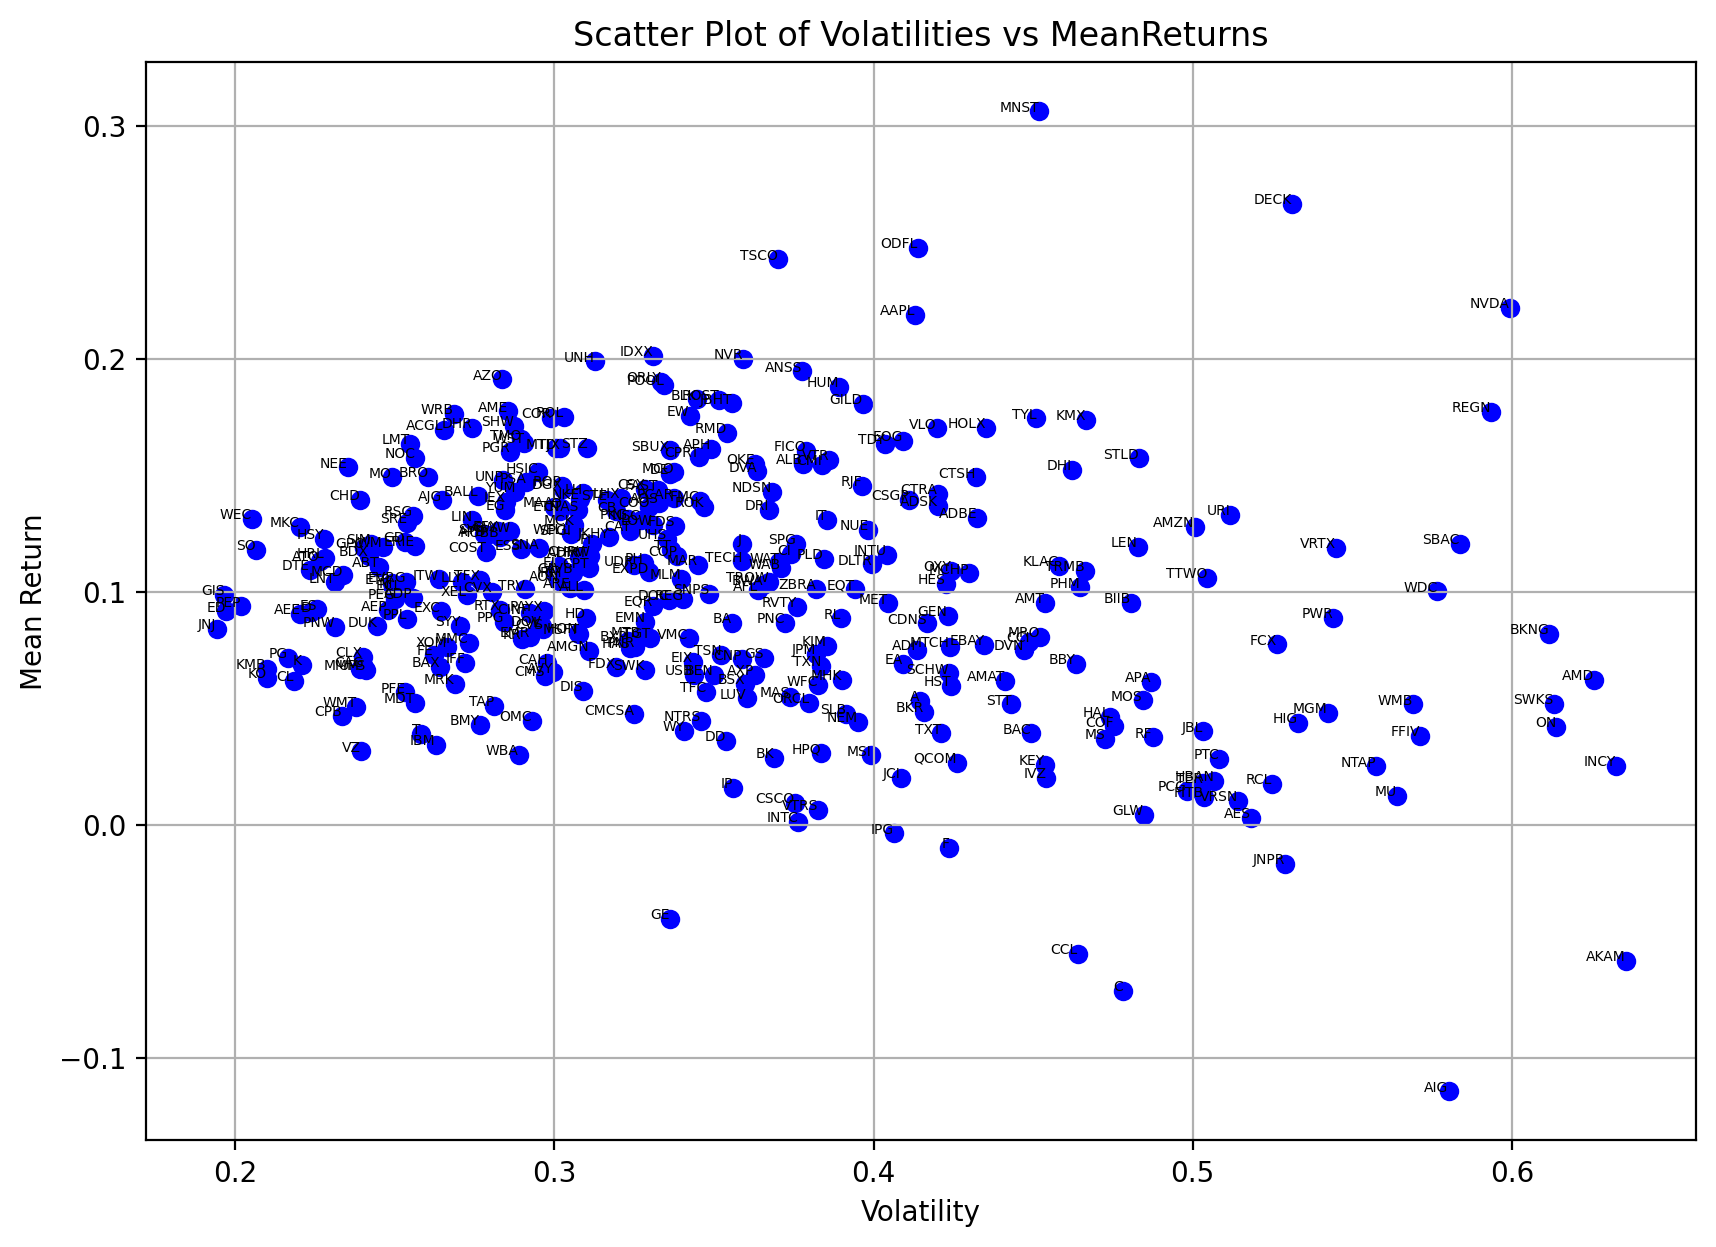

In [35]:
scatter_plot_return_volatility(sp500_log_volatility_annual, sp500_log_returns_annual, ticker_fontsize= 5)

For Sharpe Ratios one needs to find risk-free rate for each year. I do it using the data from FRED database

In [91]:
# Define the start and end dates
start_date = '2000-01-01'
end_date = '2022-12-31'

# Get risk-free rate data (e.g., 3-Month Treasury Bill, T-Bill rate) from FRED
# The ticker for the 3-Month Treasury Bill rate is 'DGS3MO'
risk_free_rates_fred = web.DataReader('DGS3MO', 'fred', start_date, end_date)

In [92]:
risk_free_rates_fred

,DGS3MO
DATE,
2000-01-03,5.48
2000-01-04,5.43
2000-01-05,5.44
2000-01-06,5.41
2000-01-07,5.38
...,...
2022-12-26,NaN
2022-12-27,4.46
2022-12-28,4.46


Then the risk-free rate should be converted to logarithm to be consistent with the other data points of log-returns

In [38]:
risk_free_log_returns = np.log(1+risk_free_rates_fred.dropna()/100)

In [39]:
annual_log_risk_free_rate = risk_free_log_returns.mean()[0]
annual_log_risk_free_rate

0.015327321920123968

In [40]:
sp500_sharpe_ratios = (sp500_log_returns_annual - annual_log_risk_free_rate) / sp500_log_volatility_annual

Plot the sharp ratios

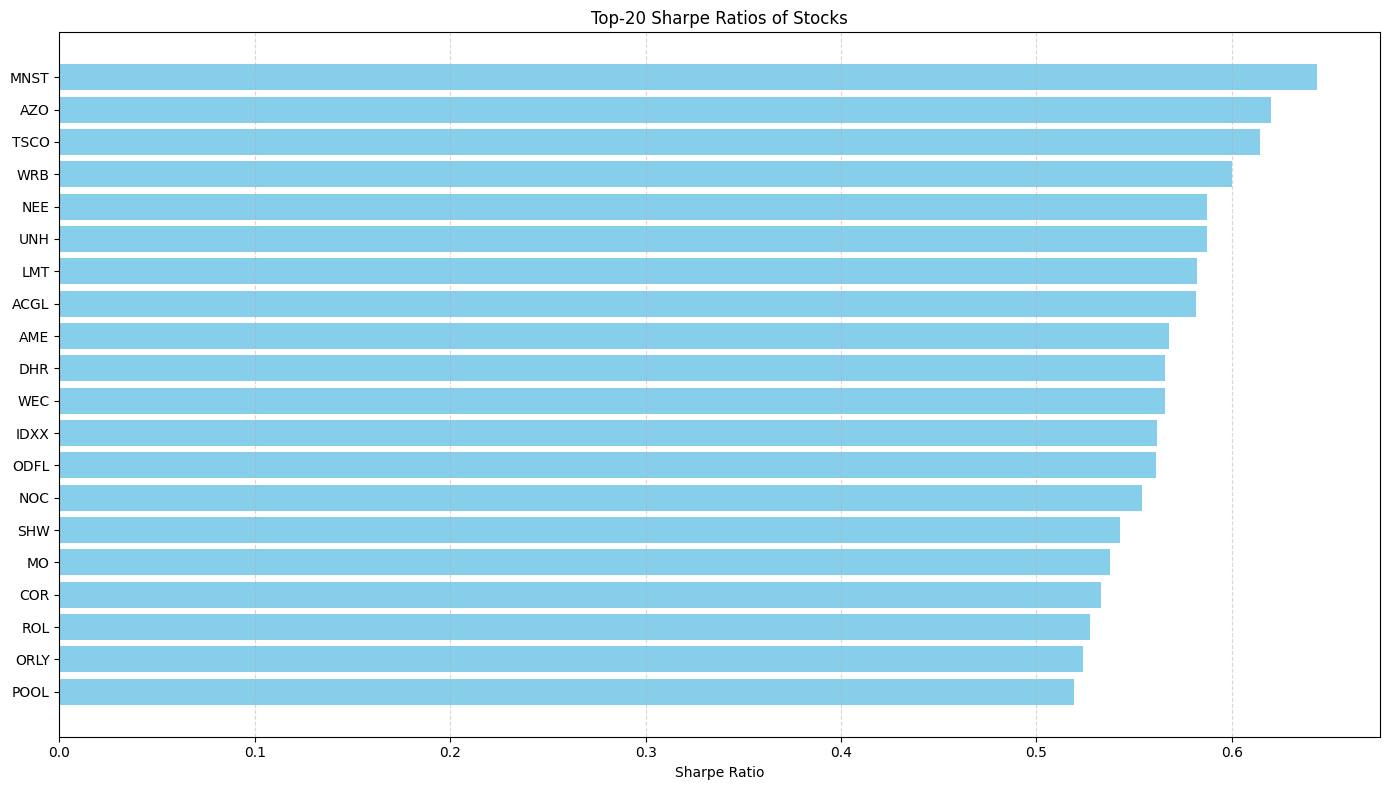

In [41]:
sp500_sharpe_ratios = sp500_sharpe_ratios.sort_values(ascending=False)  # Sort for better visualization

# Create a bar plot
plt.figure(figsize=(14, 8))
plt.barh(sp500_sharpe_ratios.index[:20], sp500_sharpe_ratios.values[:20], color='skyblue')
plt.xlabel('Sharpe Ratio')
plt.title('Top-20 Sharpe Ratios of Stocks')
plt.gca().invert_yaxis()  # Invert y-axis to show highest Sharpe ratios at the top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

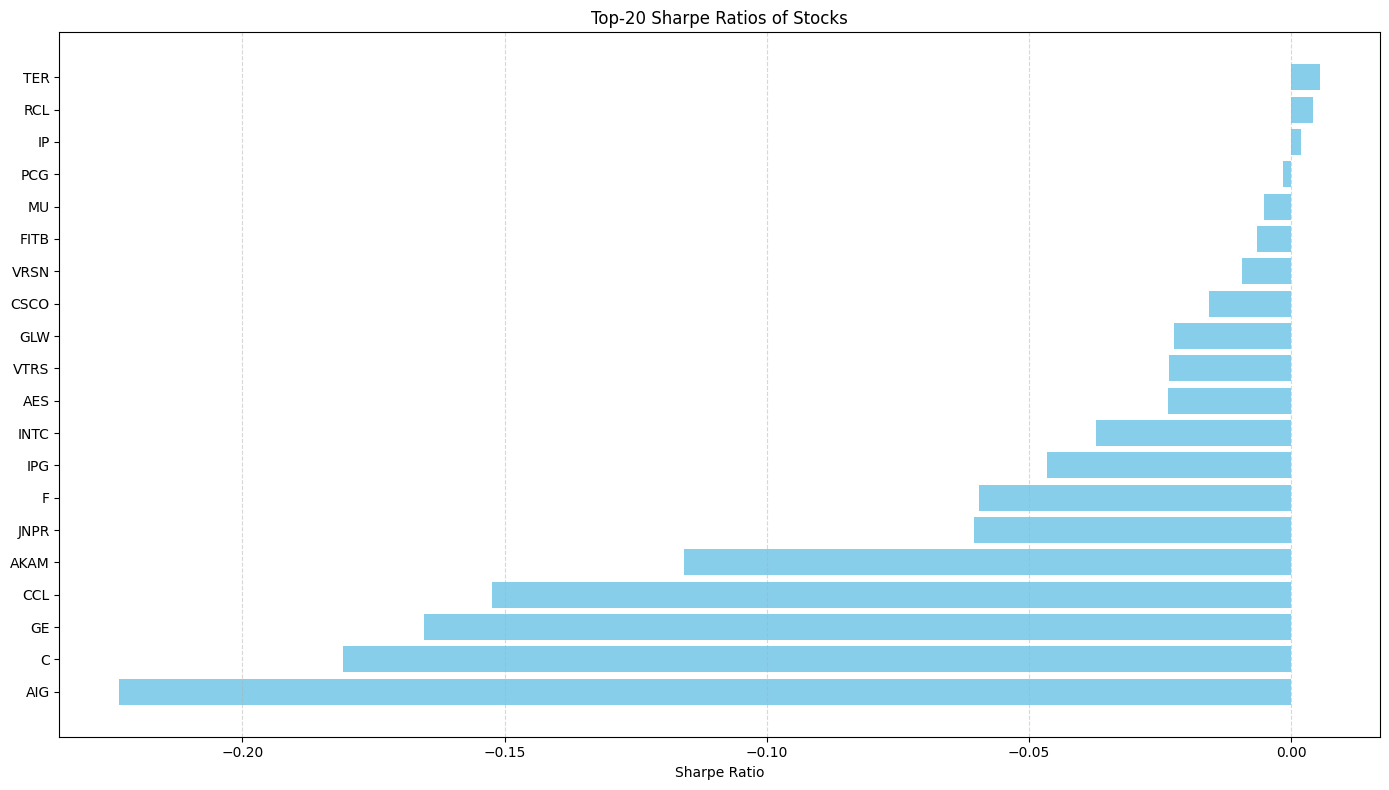

In [42]:
sp500_sharpe_ratios = sp500_sharpe_ratios.sort_values(ascending=False)  # Sort for better visualization

# Create a bar plot
plt.figure(figsize=(14, 8))
plt.barh(sp500_sharpe_ratios.index[-20:], sp500_sharpe_ratios.values[-20:], color='skyblue')
plt.xlabel('Sharpe Ratio')
plt.title('Top-20 Sharpe Ratios of Stocks')
plt.gca().invert_yaxis()  # Invert y-axis to show highest Sharpe ratios at the top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

### Essential observation: no sharpe ratio is higher than 0.65

## 2.4 Would it make sense to choose portfolio weights based only on the Sharpe ratios of the stocks in your dataset?

No! Sharpe ratio is appropriate for efficient portfolios but not forindividual assets because it ignores correlation between these assets. Only a portfolio of assets can have sharpe ratio while adding a stock to portfolio based on its sharpe ratio might not increase the portflio's sharpe ratio if the stock is already correlated with the portfolio


The main goal of constructing a portfolio is to diversify risk. Even if an asset has a lower individual Sharpe ratio, it can contribute to the overall risk-return profile if it diversifies the portfolio effectively. For example, adding an asset that moves in the opposite direction to the rest of the portfolio can decrease overall volatility and improve the portfolio's Sharpe ratio.

If you select assets based solely on their individual Sharpe ratios, you may end up with a portfolio that is not well-diversified. For example, a portfolio consisting of multiple technology stocks with high individual Sharpe ratios might look attractive but would be highly correlated and, therefore, riskier in terms of sector-specific volatility.

Recommendation: Use portfolio optimization techniques that account for the interactions between assets (e.g., mean-variance optimization) and ensure that the resulting portfolio lies on or near the efficient frontier for the best risk-adjusted performance.

## 2.5 Do the same analysis in a proper way using usual returns and annual compounding

In [44]:
# Extracting tickers from the Symbol column
sp500_tickers = sp500_table['Symbol'].tolist()

# Counting the number of tickers for verification
print(f"Number of tickers loaded: {len(sp500_tickers)}")

# Setting start date and end date
start_date = '1999-12-31'
end_date = '2022-12-31'

# Download stock price data for S&P 500 tickers
sp500_prices = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']

# Dropping columns with only missing values
sp500_prices = sp500_prices.dropna(how='all', axis=1)
# Dropping columns with more than 100 missing values
sp500_prices = sp500_prices.dropna(thresh=len(sp500_prices) - 100, axis=1)

[                       1%                       ]  3 of 503 completed

Number of tickers loaded: 503


[**********************79%*************          ]  398 of 503 completedCould not get exchangeTimezoneName for ticker 'LRCX' reason: 'chart'
[*********************100%***********************]  503 of 503 completed

9 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1999-12-31 -> 2022-12-31)')
['SW', 'GEV', 'SOLV', 'AMTM', 'VLTO', 'KVUE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 1999-12-31 -> 2022-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 946616400, endDate = 1672462800")')
['BRK.B', 'LRCX']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Find average yearly returns

In [100]:
sp500_prices_yearly = sp500_prices.resample("Y").last()
sp500_returns_yearly = sp500_prices_yearly.pct_change().iloc[1:,:]

In [101]:
# average return is geometric mean of all returns
N_years_in_sample = sp500_returns_yearly.shape[0]
sp500_returns_mean = (1+sp500_returns_yearly).prod()**(1/N_years_in_sample)-1

Find average voaltility

In [103]:
# for voaltility the more observations we have the better
sp500_returns_daily = sp500_prices.pct_change().iloc[1:,:]
sp500_volatility_daily = sp500_returns_daily.std()

# find number of days passed in reality
N_days_in_sample = (sp500_returns_daily.index[-1] - sp500_returns_daily.index[0]).days

# annualize the volatility found before
sp500_volatility_annualized = sp500_volatility_daily*np.sqrt(N_days_in_sample / N_years_in_sample)

Find annual risk-free rate

In [104]:
# risk free rates are annualized by taking arithmetical mean
risk_free_rates_daily = (risk_free_rates_fred.ffill() / 100)['DGS3MO']
risk_free_rates_yearly = risk_free_rates_daily.resample('Y').mean()

In [113]:
# check that the parsed length of risk free rates is the same as in the sample of returns
assert N_years_in_sample == risk_free_rates_yearly.shape[0]
# find mean risk-free rates
risk_free_rates_mean = (risk_free_rates_yearly+1).prod()**(1/N_years_in_sample)-1

Draw the risk-return matrix

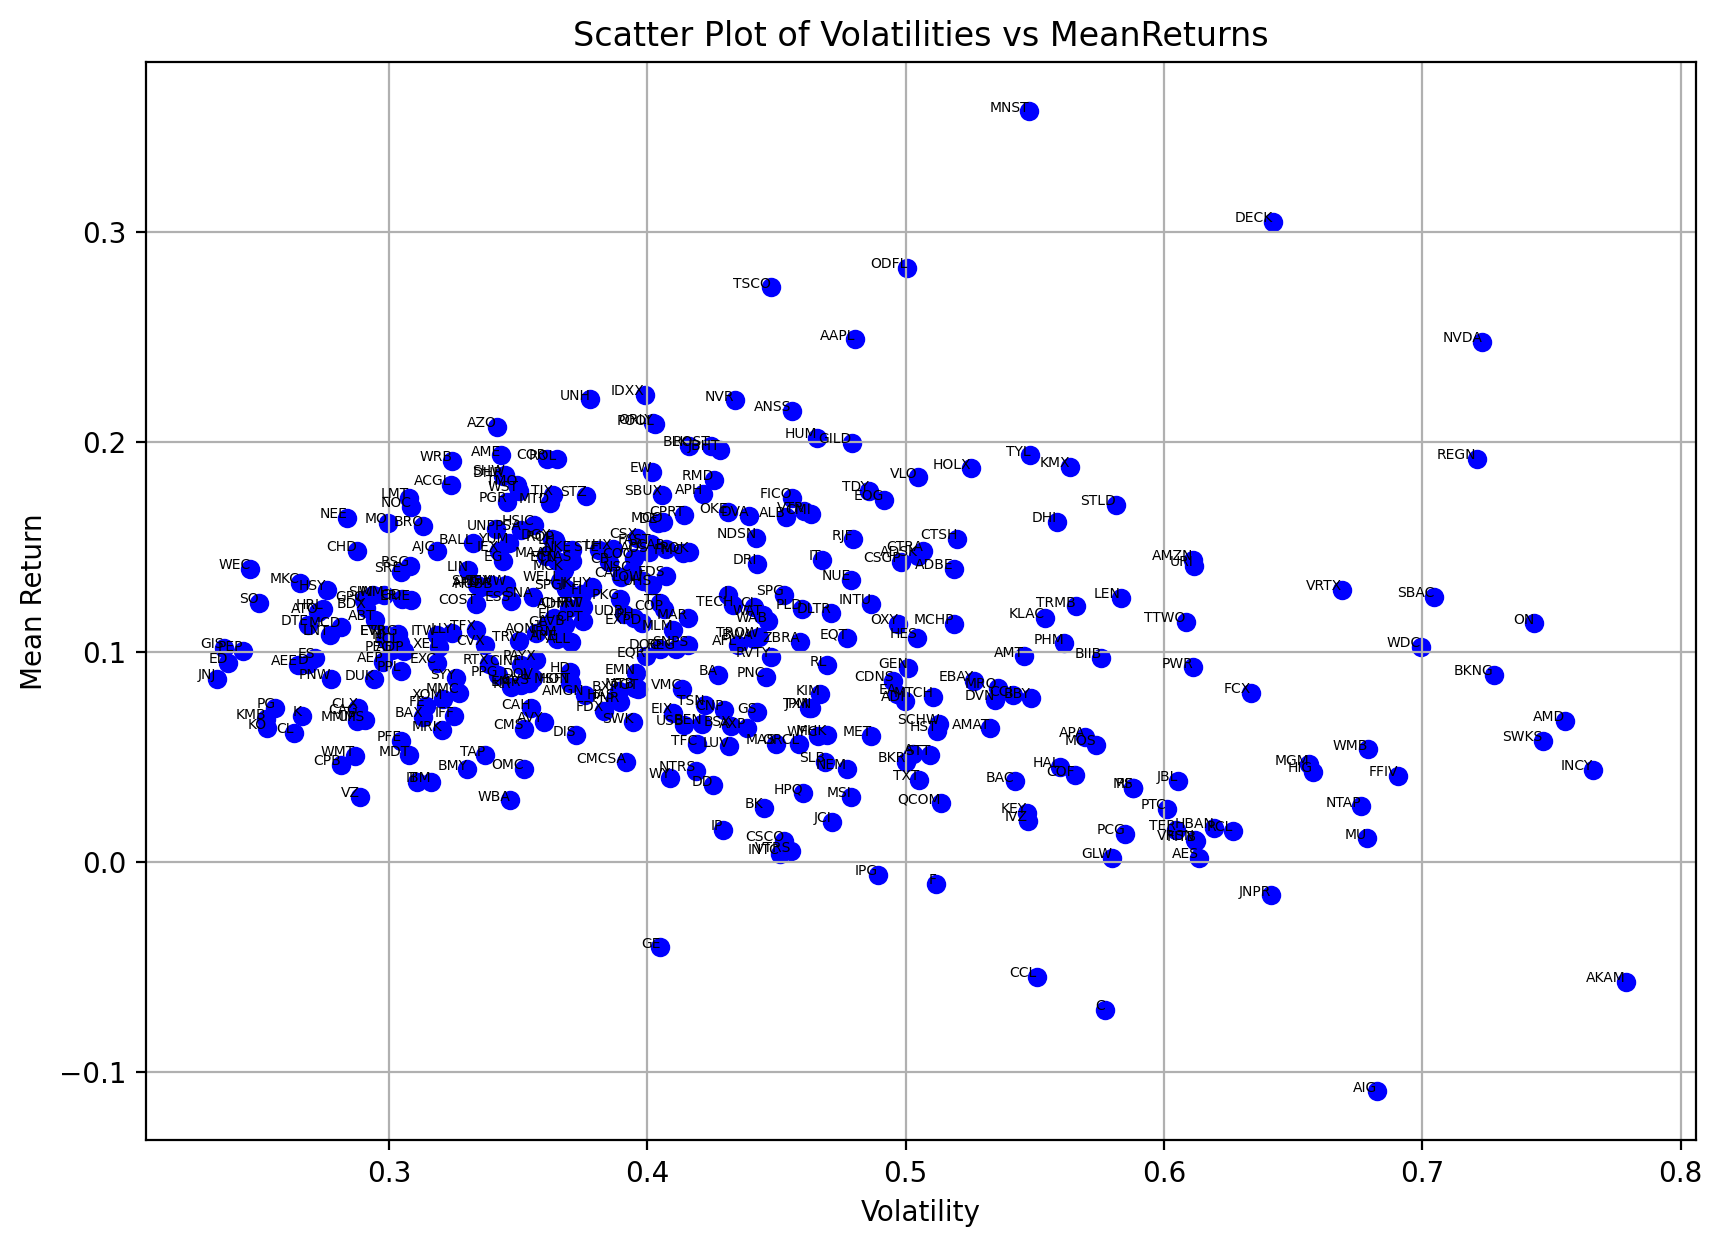

In [110]:
scatter_plot_return_volatility(sp500_volatility_annualized, sp500_returns_mean, ticker_fontsize= 5)

Find SR

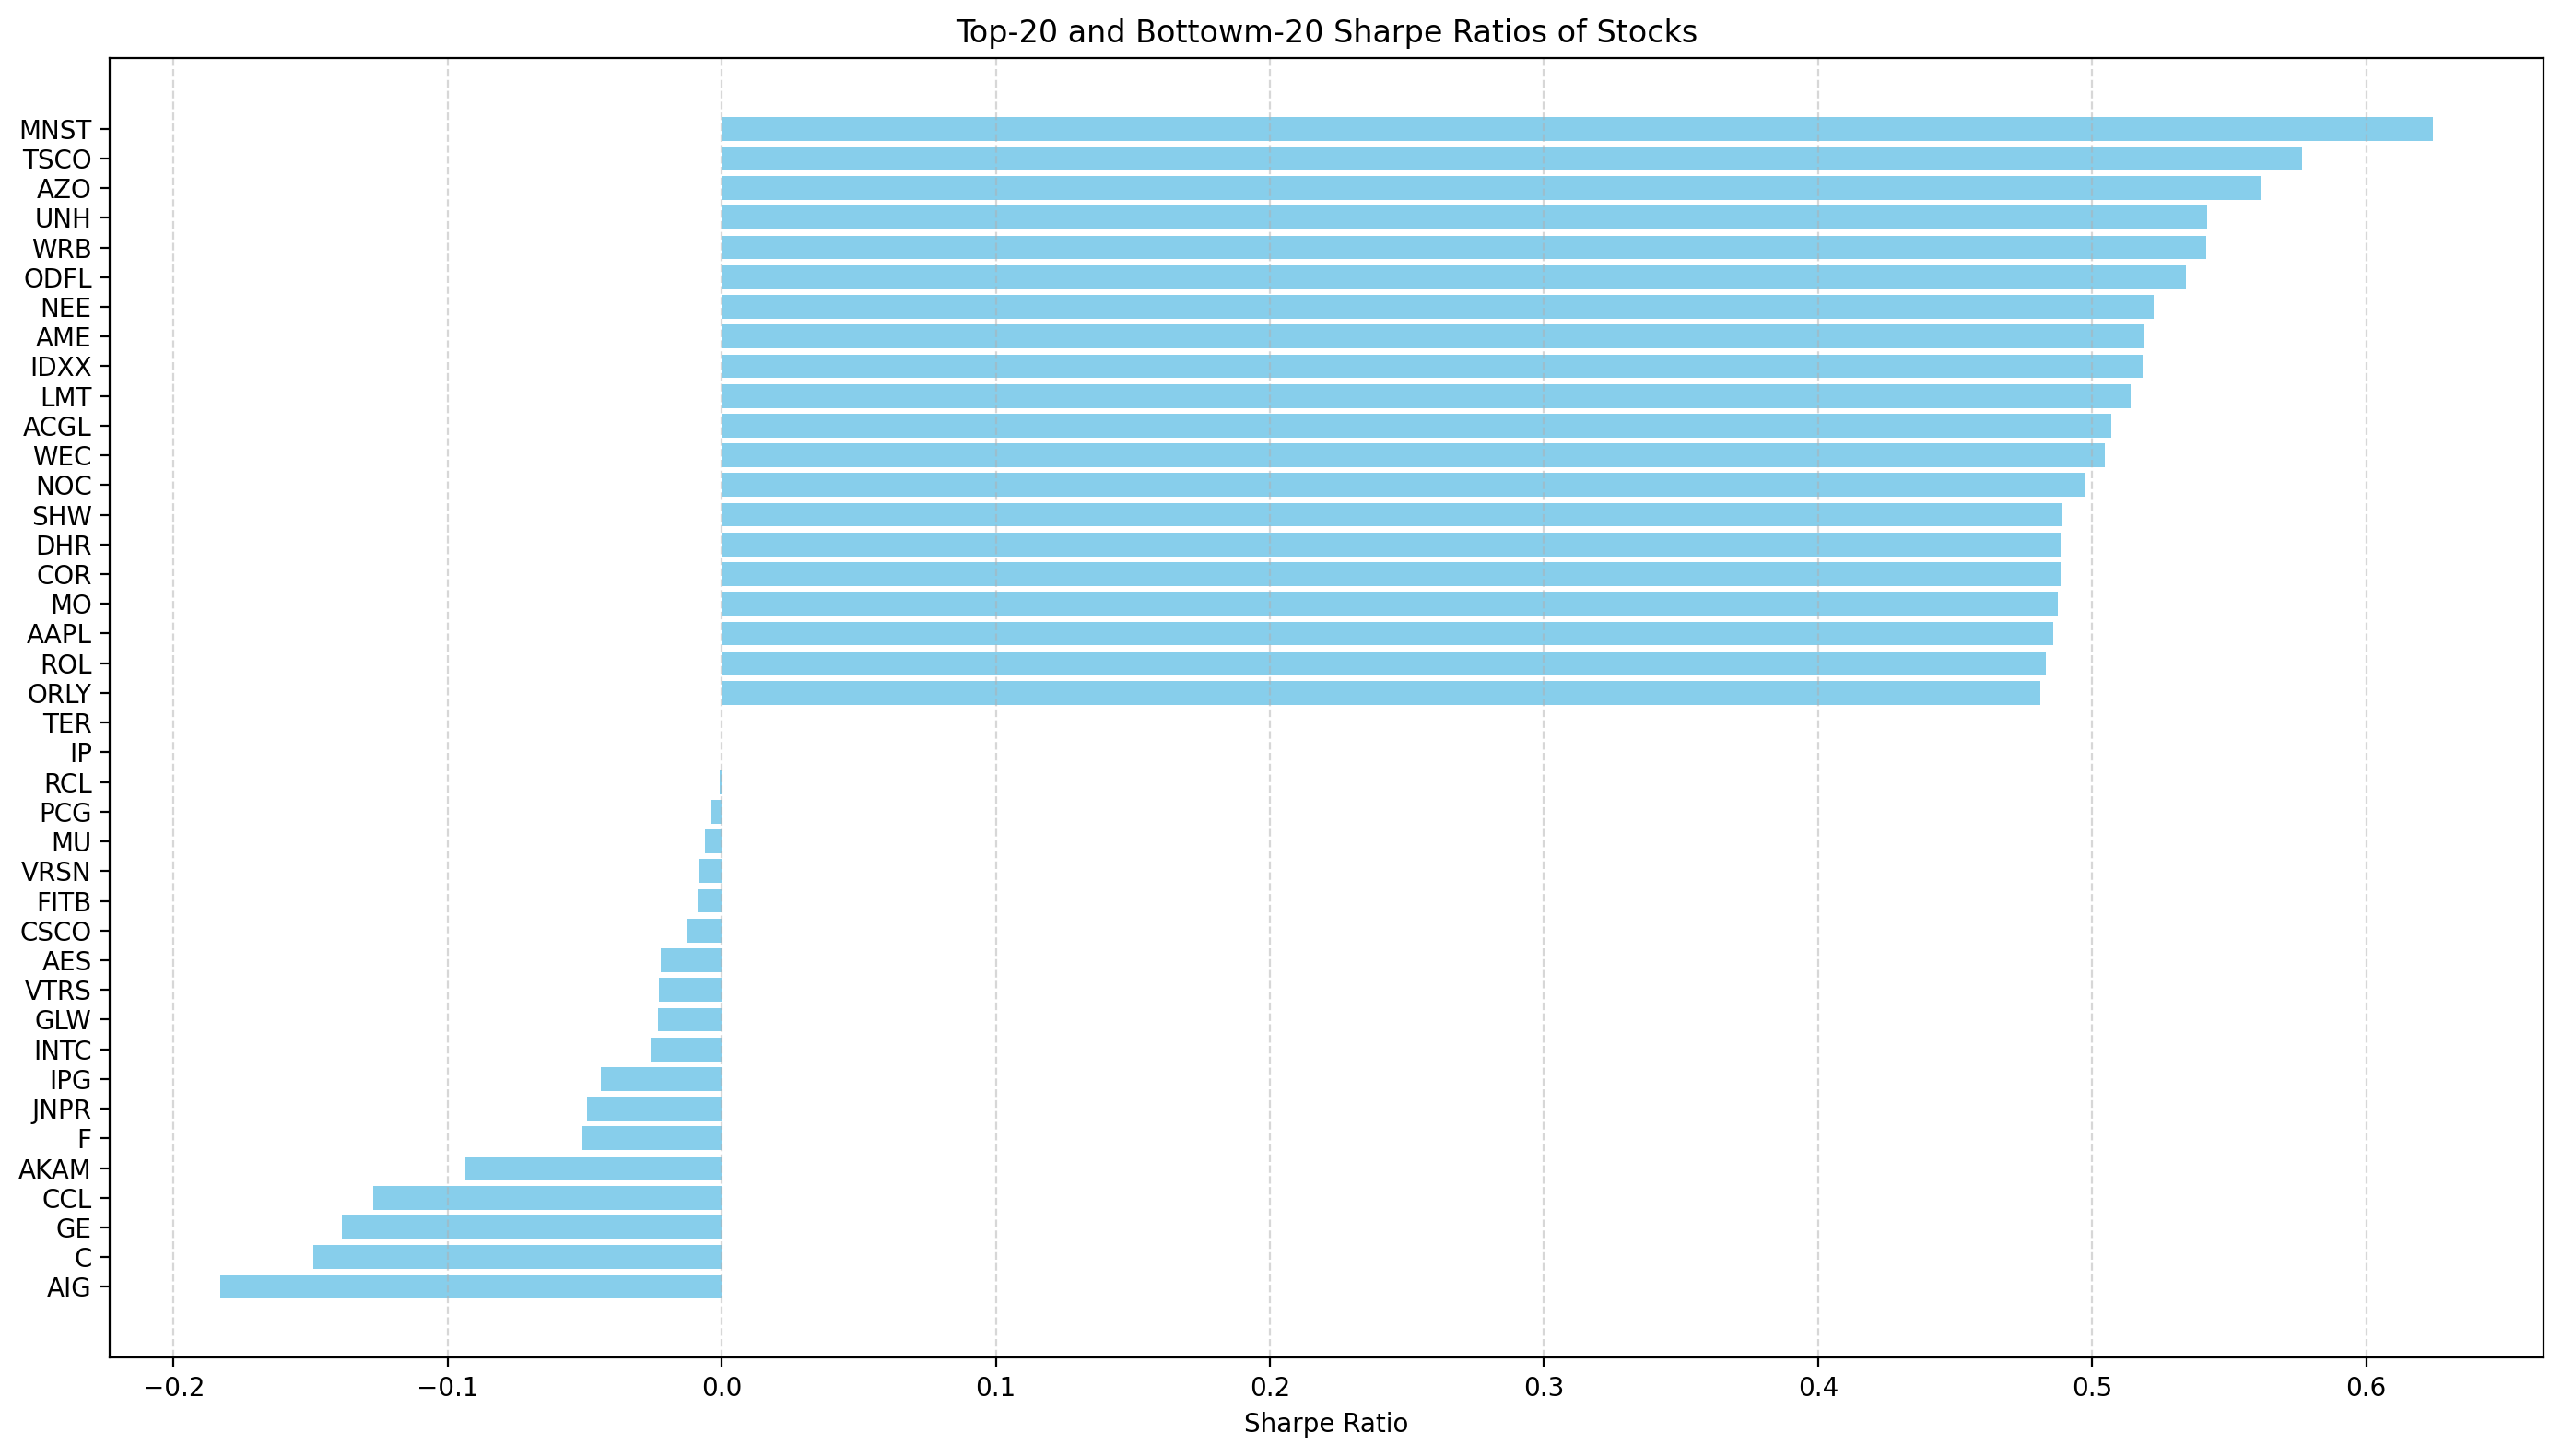

In [120]:
SR_annual = (sp500_returns_mean - risk_free_rates_mean) / sp500_volatility_annualized

SR_annual = SR_annual.sort_values(ascending=False)  # Sort for better visualization

# Create a bar plot
plt.figure(figsize=(14, 8), dpi = 200)
plt.barh(SR_annual.index[:20], SR_annual.values[:20], color='skyblue')
plt.title('Top-20 and Bottowm-20 Sharpe Ratios of Stocks')
plt.barh(SR_annual.index[-20:], SR_annual.values[-20:], color='skyblue')
plt.xlabel('Sharpe Ratio')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()